<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Introduction" data-toc-modified-id="1-Introduction-1">1 Introduction</a></span></li><li><span><a href="#2-Data-Access" data-toc-modified-id="2-Data-Access-2">2 Data Access</a></span></li><li><span><a href="#3-Error-sensitivity-evaluation" data-toc-modified-id="3-Error-sensitivity-evaluation-3">3 Error sensitivity evaluation</a></span><ul class="toc-item"><li><span><a href="#3.1-Error-added-to-all-bands" data-toc-modified-id="3.1-Error-added-to-all-bands-3.1">3.1 Error added to all bands</a></span></li><li><span><a href="#3.2-Error-added-to-specific-bands" data-toc-modified-id="3.2-Error-added-to-specific-bands-3.2">3.2 Error added to specific bands</a></span></li></ul></li><li><span><a href="#4-Plot-the-results" data-toc-modified-id="4-Plot-the-results-4">4 Plot the results</a></span></li></ul></div>

# 1 Introduction
<br>
The algorithm calibrated will be further applied in remote sensing images. Such images are susceptible to many uncertainties, such as low signal to noise ratio (SNR), atmospheric correction, and adjacent effects. Those uncertainties are called here as errors, related to differences between the in situ and satellite measurements.
In this notebook, it is evaluated the error sensitivity of the algorithm in terms of how the accuracy drops as the errors increases.

# 2 Data Access

In [1]:
# library used
import pickle
import pandas as pd
from IPython.core import display as ICD

# read data
msi_svmc_alg = open('00_Database/02_Algorithms/msi_svmc_owts.obj', 'rb') 
msi_svmc_alg = pickle.load(msi_svmc_alg)
msi_svmc_shape = msi_svmc_alg[0]
msi_svmc_678 = msi_svmc_alg[1]

test_ids = pd.read_csv('00_Database/02_Algorithms/test_ids.csv')['id']
insitu_db = pd.read_csv('00_Database/01_Tables/insitu_db.csv', index_col=0)

# define the input data
msi = insitu_db[['B2', 'B3', 'B4', 'B5','B6']]
owts = insitu_db[['OWTs']]
owts_shape = owts.applymap(lambda x: x.replace('OWT 6', 'change').
              replace('OWT 7', 'change').
              replace('OWT 8', 'change').
              replace('change', 'OWT 678'))

# 3 Error sensitivity evaluation

## 3.1 Error added to all bands

In [2]:
# library used
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from numpy.random import normal
import numpy as np
import copy as cp

# dictionaries for saving the accuracy results
msi_ba_dic = {}

# interaction to add error
for noise in np.arange(0, 0.7, 0.01):
    
    for k in range(1,1000):
        
        # define the test ids
        test = test_ids

        # defines the true values of the test dataset
        true = owts.loc[test,:]
        
        # add errors to bands
        msi_noise = msi.applymap(lambda x: x*normal(1, noise))
        
        # compute the mean MAPE
        mape = int(((abs((msi_noise - msi)/msi)).mean().mean())*100)
        
        # chooses the algorithm input
        msi_norm = msi_noise.divide(msi_noise.sum(axis=1), axis='rows')
        msi_b3 = msi_noise[['B3']]
        
        # predict the OWTs in the test dataset (shape)
        msi_svmc_predicted = msi_svmc_shape.predict(msi_norm.loc[test,:].values)
        msi_svmc_predicted = pd.DataFrame(msi_svmc_predicted,
                                          index=test,
                                          columns=['msi_predicted'])

        # predict the OWTs in the test dataset (OWTs 7, 8, and 9)
        msi_owt678_predicted_id = msi_svmc_predicted[msi_svmc_predicted['msi_predicted'] == 'OWT 678'].index
        msi_svmc_predicted_678 = msi_svmc_678.predict(msi_b3.loc[msi_owt678_predicted_id,:].values)
        msi_svmc_predicted_678 = pd.DataFrame(msi_svmc_predicted_678,
                                              index=msi_owt678_predicted_id,
                                              columns=['msi_predicted'])

        # concatenate all predicted OWTs
        msi_svmc_predicted.update(msi_svmc_predicted_678)

        # creates an evaluation dataset, concatenate predicted OWTs and the true OWTs
        msi_evaluation = msi_svmc_predicted.join(true)

        # computes balanced accuracy, precision, and recall
        msi_ba = balanced_accuracy_score(msi_evaluation['OWTs'],
                                         msi_evaluation['msi_predicted'])

        # saves the statistical results
        msi_ba_dic[int(noise*100), mape, k] = [int(noise*100), mape, k, msi_ba] 

# save results in dataframes
ba_noise = pd.DataFrame(msi_ba_dic.values(), columns=['noise', 'mape','interaction', 'ba']).round(2)

## 3.2 Error added to specific bands

In [3]:
# dictionaries for saving the accuracy results
msi_ba_dic_bands = {}


# interaction for choosing the band to add error
for z in ['B2', 'B3', 'B4', 'B5', 'B6']:

    # add error
    for noise in np.arange(0, 0.7, 0.01):

        for k in range(1,1000):

            # define the test ids
            test = test_ids

            # defines the true values of the test dataset
            true = owts.loc[test,:]

            # add noise to bands
            msi_noise = cp.copy(msi)
            msi_noise[[z]] = msi_noise[[z]].applymap(lambda x: x*normal(1, noise))
            
            # compute the mean MAPE
            mape = int(((abs((msi_noise[[z]] - msi[[z]])/msi[[z]])).mean())*100)
            
            # chooses the algorithm input
            msi_norm = msi_noise.divide(msi.sum(axis=1), axis='rows')
            msi_b3 = msi_noise[['B3']]

            # predict the OWTs in the test dataset (shape)
            msi_svmc_predicted = msi_svmc_shape.predict(msi_norm.loc[test,:].values)
            msi_svmc_predicted = pd.DataFrame(msi_svmc_predicted,
                                              index=test,
                                              columns=['msi_predicted'])

            # predict the OWTs in the test dataset (OWTs 7, 8, and 9)
            msi_owt678_predicted_id = msi_svmc_predicted[msi_svmc_predicted['msi_predicted'] == 'OWT 678'].index
            msi_svmc_predicted_678 = msi_svmc_678.predict(msi_b3.loc[msi_owt678_predicted_id,:].values)
            msi_svmc_predicted_678 = pd.DataFrame(msi_svmc_predicted_678,
                                                  index=msi_owt678_predicted_id,
                                                  columns=['msi_predicted'])

            # concatenate all predicted OWTs
            msi_svmc_predicted.update(msi_svmc_predicted_678)

            # creates an evaluation dataset, concatenate predicted OWTs and the true OWTs
            msi_evaluation = msi_svmc_predicted.join(true)

            # computes balanced accuracy, precision, and recall
            msi_ba = balanced_accuracy_score(msi_evaluation['OWTs'],
                                             msi_evaluation['msi_predicted'])

            # saves the statistical results
            msi_ba_dic_bands[z, int(noise*100), mape, k] = [z, int(noise*100), mape, k, msi_ba] 

# save results in dataframes
msi_ba_dic_bands = pd.DataFrame(msi_ba_dic_bands.values(), columns=['band', 'noise', 'mape','interaction', 'ba']).round(2)

# 4 Plot the results

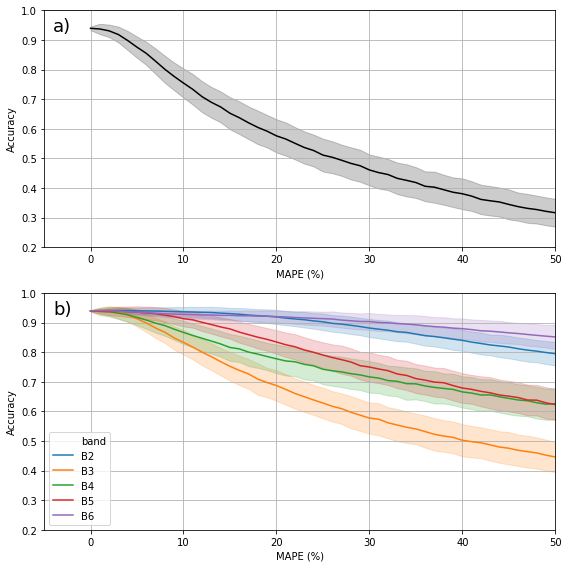

In [13]:
# library used
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 1, 1)
sns.lineplot(x='mape',
             y='ba',
             data=ba_noise,
             color='black',
             ci='sd',
             ax=ax)

ax.set_ylim(0.2,1)
ax.set_xlim(-5,50)

ax.set_ylabel('Accuracy')
ax.set_xlabel('MAPE (%)')

ax.grid()
ax.text(-4,0.93, 'a)', fontsize=18)

ax1 = plt.subplot(2, 1, 2)

sns.lineplot(x='mape',
            y='ba',
            hue='band',
            data=msi_ba_dic_bands,
             ci='sd',
             ax=ax1)
ax1.grid()
ax1.set_ylim(0.2,1);
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('MAPE (%)');
ax1.set_xlim(-5,50);
ax1.text(-4,0.93, 'b)', fontsize=18)

plt.tight_layout()

In [14]:
fig.savefig('00_Database/00_Figures/Noise_sensivity.png', dpi=300)